<a href="https://colab.research.google.com/github/nahumsa/Entanglement-VAE/blob/scinet/Scinet%20Entanglement%20Witness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating entangled and separable states with qutip

## Installing dependencies

In [1]:
!git clone -b scinet https://github.com/nahumsa/Entanglement-VAE.git

Cloning into 'Entanglement-VAE'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 73 (delta 32), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [2]:
!pip install qutip

     |████████████████████████████████| 3.5MB 2.8MB/s 
  Created wheel for qutip: filename=qutip-4.5.0-cp36-cp36m-linux_x86_64.whl size=12885043 sha256=3021b1314b88a158a33875607a707a9b12ea4a179fed61b6b4257f0378c114cb
  Stored in directory: /root/.cache/pip/wheels/c9/85/e8/3fbad9a0816141b4c5f1d73d8a880ed91265fea84192cbe37b
Successfully built qutip


In [3]:
% cd Entanglement-VAE/

/content/Entanglement-VAE


## Creating the dataset

We want to take the partial transpose of the density matrix and check if it $\rho > 0$. [link](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion)

Here we are following the Perez-Horondecki criterion, if the partial transpose of the density matrix is negative, the state has to be entangled. 

Because it the state is separable, it will be positive definite by definition.

In [4]:
try:
  %tensorflow_version 1.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.compat.v1.set_random_seed(1234)

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.


In [0]:
from itertools import product
import qutip as qutip
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def measurement(density_matrix, base, name_base):
  """Measuring the quantum state on a given basis.
  """
  _measurements_names = []
  _measurements = []

  for (name_1, meas_1),(name_2,meas_2) in product(zip(name_base, base),zip(name_base, base)):
    #Ignore the II measurement because it is always 1
    if name_1 == 'I' and name_2 == 'I':
      pass
    else:
      measurement_op = qutip.tensor(meas_1,meas_2)
      _measurements.append(qutip.expect(measurement_op, density_matrix))
      _measurements_names.append(name_1 + name_2)

  return [i for i in zip(_measurements, _measurements_names)]

def create_density_matrix(base,name_base):
  """ Create a random density matrix."""

  for (name_1, basis_1),(name_2, basis_2) in product(zip(name_base, base),zip(name_base, base)):
    if name_1 == 'I' and name_2 == 'I':
      density_matrix = 0.25*qutip.tensor(basis_1, basis_2)
    else: 
      density_matrix += 0.25*np.random.rand()*qutip.tensor(basis_1,basis_2)
  
  return density_matrix

def create_dataset(n_samples):
  
  _states = []
  _labels = []
  _measurements = []

  #Basis Measured
  name_basis = ['I', 'X', 'Y', 'Z']
  basis = [qutip.identity(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]



  for _ in range(n_samples):    
    density = qutip.rand_dm(4, density=0.75, dims=[[2,2],[2,2]])
    
    #Partial Transpose
    density_partial_T = qutip.partial_transpose(density, [0,1])    
  
    #Labels: 1 if entangled 0 if separable (PPT Criterion)
    if (density_partial_T.eigenenergies() < 0).any():
      _labels.append(1)
  
    else:      
      _labels.append(0)  

    _states.append(density)  
  
    val_measurements = measurement(density_matrix=density, 
                                   base=basis, 
                                   name_base=name_basis)
  
    _measurements.append(val_measurements)
    
  return _states, _measurements, _labels

In [0]:
samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

## Helper functions to unpack data

In [0]:
#Unpacking the training data
def create_x(measurement):
  """Create an list with measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:      
      aux.append(result)
    X.append(aux)
  return X

def create_x_correlated(measurement):
  """Create an list with  correlated measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:
      if name[0] == 'I' or name[1] == 'I':  
        pass
      else:
        aux.append(result)
    X.append(aux)
  return X

def create_x_local(measurement):
  """Create an list with local measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:
      if name[0] == 'I' or name[1] == 'I':  
        aux.append(result)        
    X.append(aux)
  return X

# Scinet 

## All Measurements as input and local measurements as question

In [8]:
#Creating training and test data
X_train_inp = np.array(create_x(measurements_train))
X_test_inp = np.array(create_x(measurements_test))
X_train_q = np.array(create_x_local(measurements_train))
X_test_q = np.array(create_x_local(measurements_test))

#Predictions
Y_train = np.array(labels_train)
Y_test = np.array(labels_test)
#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X Input: {X_train_inp.shape} \n X Question: {X_train_q.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X Input: (5000, 15) 
 X Question: (5000, 6) 
 Y:(5000, 2)


In [0]:
import os
# run params
SECTION = 'scinet'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from keras.models import Model
from Models.ENT_VAE import ScinetSoftmax

#Parameters
input_dimension = (X_train_inp.shape[1],)
question_dimension = (X_train_q.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = True
dropout = True
ZDIM = 2

#Defining the Beta-VAE
scinet = ScinetSoftmax(input_dim = input_dimension
                            , encoder_dense_units = encoder_dense
                            , decoder_dense_units = decoder_dense
                            , z_dim = ZDIM
                            , q_dim = question_dimension
                            , use_batch_norm = batch_norm
                            , use_dropout= dropout
                            )

z_mu_b = scinet.encoder.predict(X_test_inp)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
scinet.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)


# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = scinet.train( x_train = [X_train_inp,X_train_q]
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    #, validation_data = ([X_test_inp,X_test_q], Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    #, callbacks = callbacks
                    )

Accuracy: 0.9102000005722046


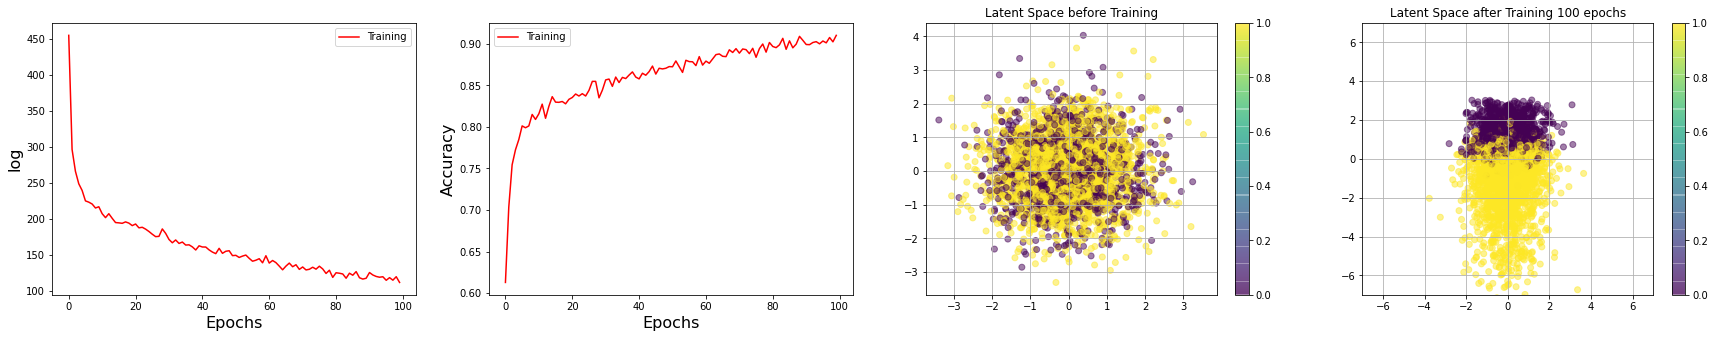

In [12]:
#Metrics
loss = history.history['loss']
accuracy = history.history['acc']

#val_loss = history.history['val_loss']
#val_accuracy = history.history['val_acc']

print(f'Accuracy: {accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,5))


ax1.plot(epochs, loss, 'r', label='Training')
#ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
#ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_0 = scinet.encoder.predict(X_test_inp)
ims = ax4.scatter(z_mu_0[:, 0], z_mu_0[:, 1], alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.set_ylim(-7,7)
ax4.set_xlim(-7,7)
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()

## All Measurements as input and correlated measurements as question

In [13]:
#Creating training and test data
X_train_inp = np.array(create_x(measurements_train))
X_test_inp = np.array(create_x(measurements_test))
X_train_q = np.array(create_x_correlated(measurements_train))
X_test_q = np.array(create_x_correlated(measurements_test))

#Predictions
Y_train = np.array(labels_train)
Y_test = np.array(labels_test)
#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X Input: {X_train_inp.shape} \n X Question: {X_train_q.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X Input: (5000, 15) 
 X Question: (5000, 9) 
 Y:(5000, 2)


In [0]:
import os
# run params
SECTION = 'scinet'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from keras.models import Model
from Models.ENT_VAE import ScinetSoftmax

#Parameters
input_dimension = (X_train_inp.shape[1],)
question_dimension = (X_train_q.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = True
dropout = True
ZDIM = 2

#Defining the Beta-VAE
scinet = ScinetSoftmax(input_dim = input_dimension
                            , encoder_dense_units = encoder_dense
                            , decoder_dense_units = decoder_dense
                            , z_dim = ZDIM
                            , q_dim = question_dimension
                            , use_batch_norm = batch_norm
                            , use_dropout= dropout
                            )

z_mu_b = scinet.encoder.predict(X_test_inp)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
scinet.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)


# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = scinet.train( x_train = [X_train_inp,X_train_q]
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    #, validation_data = ([X_test_inp,X_test_q], Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    #, callbacks = callbacks
                    )

Accuracy: 0.8893999995231628


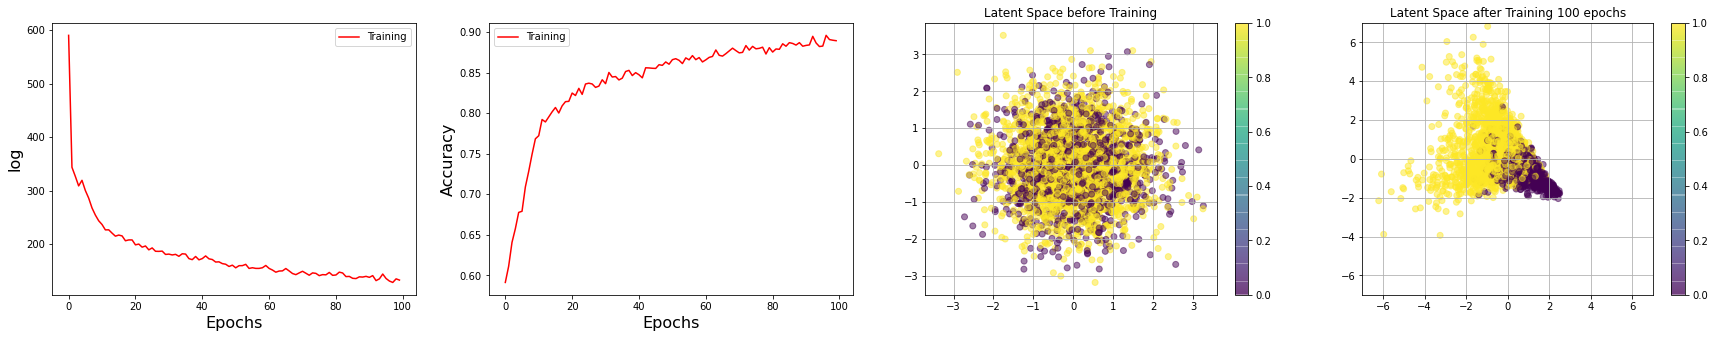

In [17]:
#Metrics
loss = history.history['loss']
accuracy = history.history['acc']

#val_loss = history.history['val_loss']
#val_accuracy = history.history['val_acc']

print(f'Accuracy: {accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,5))


ax1.plot(epochs, loss, 'r', label='Training')
#ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
#ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_0 = scinet.encoder.predict(X_test_inp)
ims = ax4.scatter(z_mu_0[:, 0], z_mu_0[:, 1], alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.set_ylim(-7,7)
ax4.set_xlim(-7,7)
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()

## Correlated Measurements as input and local measurements as question

In [18]:
#Creating training and test data
X_train_inp = np.array(create_x_correlated(measurements_train))
X_test_inp = np.array(create_x_correlated(measurements_test))
X_train_q = np.array(create_x_local(measurements_train))
X_test_q = np.array(create_x_local(measurements_test))

#Predictions
Y_train = np.array(labels_train)
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X Input: {X_train_inp.shape} \n X Question: {X_train_q.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X Input: (5000, 9) 
 X Question: (5000, 6) 
 Y:(5000, 2)


In [0]:
import os
# run params
SECTION = 'scinet'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from keras.models import Model
from Models.ENT_VAE import ScinetSoftmax

#Parameters
input_dimension = (X_train_inp.shape[1],)
question_dimension = (X_train_q.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = True
dropout = True
ZDIM = 2

#Defining the Beta-VAE
scinet = ScinetSoftmax(input_dim = input_dimension
                            , encoder_dense_units = encoder_dense
                            , decoder_dense_units = decoder_dense
                            , z_dim = ZDIM
                            , q_dim = question_dimension
                            , use_batch_norm = batch_norm
                            , use_dropout= dropout
                            )

z_mu_b = scinet.encoder.predict(X_test_inp)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
scinet.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)


# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = scinet.train( x_train = [X_train_inp,X_train_q]
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    #, validation_data = ([X_test_inp,X_test_q], Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    #, callbacks = callbacks
                    )

Accuracy: 0.8726000000953674


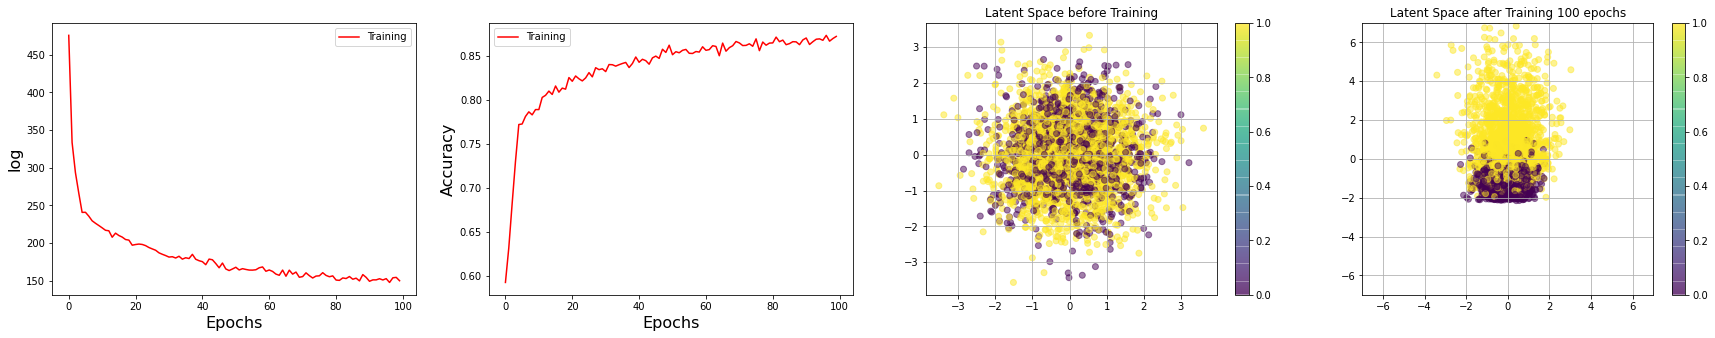

In [22]:
#Metrics
loss = history.history['loss']
accuracy = history.history['acc']

#val_loss = history.history['val_loss']
#val_accuracy = history.history['val_acc']

print(f'Accuracy: {accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,5))


ax1.plot(epochs, loss, 'r', label='Training')
#ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
#ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_0 = scinet.encoder.predict(X_test_inp)
ims = ax4.scatter(z_mu_0[:, 0], z_mu_0[:, 1], alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.set_ylim(-7,7)
ax4.set_xlim(-7,7)
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()

## Local measurements as input and Correlated Measurements as quesiton

In [23]:
#Unpacking the training data
def create_x(measurement):
  """Create an list with measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:      
      aux.append(result)
    X.append(aux)
  return X

def create_x_correlated(measurement):
  """Create an list with  correlated measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:
      if name[0] == 'I' or name[1] == 'I':  
        pass
      else:
        aux.append(result)
    X.append(aux)
  return X

def create_x_local(measurement):
  """Create an list with local measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:
      if name[0] == 'I' or name[1] == 'I':  
        aux.append(result)        
    X.append(aux)
  return X

#Creating training and test data
X_train_inp = np.array(create_x_local(measurements_train))
X_test_inp = np.array(create_x_local(measurements_test))
X_train_q = np.array(create_x_correlated(measurements_train))
X_test_q = np.array(create_x_correlated(measurements_test))

#Predictions
Y_train = np.array(labels_train)
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X Input: {X_train_inp.shape} \n X Question: {X_train_q.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X Input: (5000, 6) 
 X Question: (5000, 9) 
 Y:(5000, 2)


In [0]:
import os
# run params
SECTION = 'scinet'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from keras.models import Model
from Models.ENT_VAE import ScinetSoftmax

#Parameters
input_dimension = (X_train_inp.shape[1],)
question_dimension = (X_train_q.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = True
dropout = True
ZDIM = 2

#Defining the Beta-VAE
scinet = ScinetSoftmax(input_dim = input_dimension
                            , encoder_dense_units = encoder_dense
                            , decoder_dense_units = decoder_dense
                            , z_dim = ZDIM
                            , q_dim = question_dimension
                            , use_batch_norm = batch_norm
                            , use_dropout= dropout
                            )

z_mu_b = scinet.encoder.predict(X_test_inp)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
scinet.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)


# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = scinet.train( x_train = [X_train_inp,X_train_q]
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    #, validation_data = ([X_test_inp,X_test_q], Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    #, callbacks = callbacks
                    )

Accuracy: 0.861600000667572


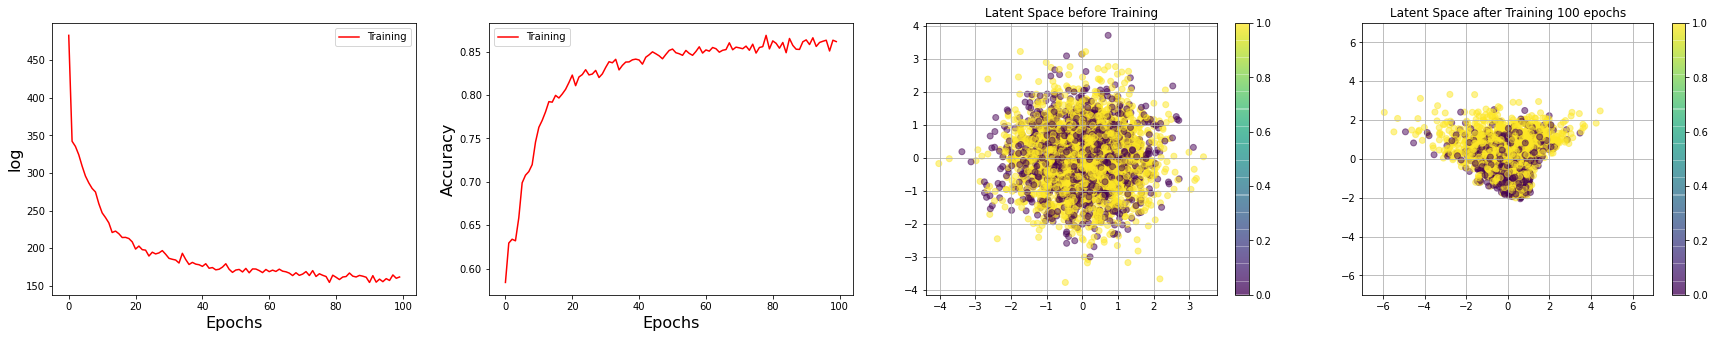

In [27]:
#Metrics
loss = history.history['loss']
accuracy = history.history['acc']

#val_loss = history.history['val_loss']
#val_accuracy = history.history['val_acc']

print(f'Accuracy: {accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,5))


ax1.plot(epochs, loss, 'r', label='Training')
#ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
#ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_0 = scinet.encoder.predict(X_test_inp)
ims = ax4.scatter(z_mu_0[:, 0], z_mu_0[:, 1], alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.set_ylim(-7,7)
ax4.set_xlim(-7,7)
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()